Добавленные признаки:
   + количество ненормативной лексики
   + количество положительно окрашенных слов
   + количество отрицательно окрашенных слов 
   + количество подписчиков в паблике
   ------------------------------------
   Тексты лемматизированы

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('data_preprocessed_final.csv', sep = '\t', encoding='cp1251')

In [3]:
y = data['LikesNormAvg'].astype(float)
true_likes = data['Likes'].astype(int)
coef = data['AvgLikes'].astype(float)/100
texts = data['Text']
lemtexts = data['LemText']
categ = data['Type']
followers = data['Followers']
X = data.drop(['Text', 'LikesNormAvg', 'LikesNormFlw', 'Likes', 'AvgLikes', 
       'GroupId', 'Date', 'LemText', 'Unnamed: 0', 'Type'], axis=1)

In [4]:
types = pd.get_dummies(categ)
X = pd.concat((X, types), axis=1).astype(int)

In [5]:
X.head(2)

,AttPhoto,AttLink,AttAudio,AttVideo,IsAdd,Len,Followers,SentNeg,SentPos,ObsCount,copy,post
0,0,0,0,0,0,14,377346,3,0,0,0,1
1,1,1,0,0,0,18,377346,0,1,0,0,1


In [6]:
X.columns

Index(['AttPhoto', 'AttLink', 'AttAudio', 'AttVideo', 'IsAdd', 'Len',
       'Followers', 'SentNeg', 'SentPos', 'ObsCount', 'copy', 'post'],
      dtype='object')

In [7]:
def load_stop_words():
    file = open('../preprocessing/stop_words.txt', 'r')
    lines = file.readlines()
    stop_words = []
    for line in lines:
        stop_words.append(line.strip())
    return stop_words

In [8]:
sw = load_stop_words()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', stop_words=sw, lowercase=True, min_df = 2)

In [10]:
texts_tfidf = tfidf.fit_transform(lemtexts)

In [11]:
texts_tfidf.shape

(6689, 15572)

In [12]:
state = 27

In [13]:
from sklearn.model_selection import KFold, cross_val_predict
kf = KFold(n_splits = 5, random_state = state)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils.validation import check_array as check_arrays
def quality(y_true, y_pred):
    print('MAE:')
    print(mean_absolute_error(y_true, y_pred))
    print('MSE:')
    print(mean_squared_error(y_true, y_pred))
    print('RMSE:')
    print(np.sqrt(mean_squared_error(y_true, y_pred)))
#     print('MAPE')
#     print (format(mean_absolute_percentage_error(y_true, y_pred), '.8f'))

In [40]:
import matplotlib.pyplot as plt
% matplotlib inline
def plot_error(y_true, y_pred):
    fig = plt.figure(figsize =  (15, 6))
    plt.xlabel('post ID', fontsize=14)
    plt.ylabel('Likes', fontsize=14)
    plt.plot(y_true, color = 'grey', alpha = 0.9, label = 'True')
    plt.plot(y_pred, color = 'black',  label = 'Prediction' )
    plt.legend()

In [16]:
from scipy.sparse import csr_matrix, hstack, vstack
X_sparse = csr_matrix(X)
X_all_sparse =  hstack((X_sparse, texts_tfidf))

## Random Forest 100

In [17]:
from sklearn.ensemble import RandomForestRegressor
frst = RandomForestRegressor(n_estimators = 100)

In [18]:
# from sklearn.model_selection import GridSearchCV
# parameters = { 'max_depth' : (None, 3, 6), 'n_estimators' : [20, 50, 100],  "min_samples_split": [2, 4, 6]}
# gs = GridSearchCV(frst, parameters, verbose = 10)

In [19]:
# gs.fit(X_all_sparse, y)

In [20]:
pred_raw = cross_val_predict(frst, X_all_sparse, y, cv = kf, verbose = 10)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 31.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 31.7min finished


MAE:
43.349567085
MSE:
5105.6726718
RMSE:
71.4539898942


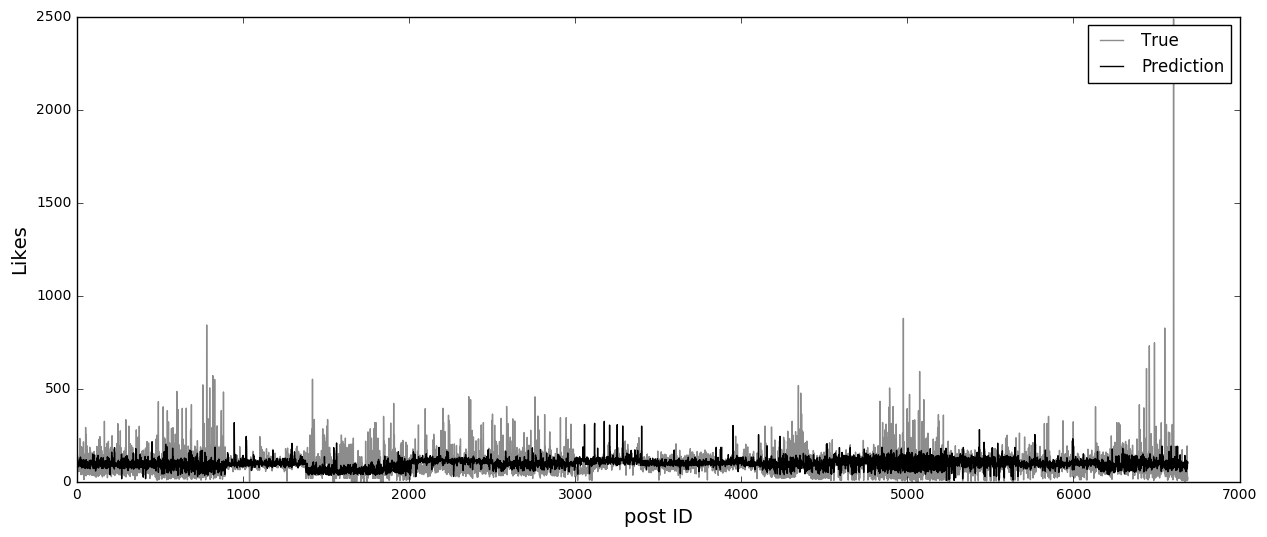

In [41]:
quality(y, pred_raw)
plot_error(y, pred_raw)

MAE:
997.140488433
MSE:
6708336.2042
RMSE:
2590.04559887


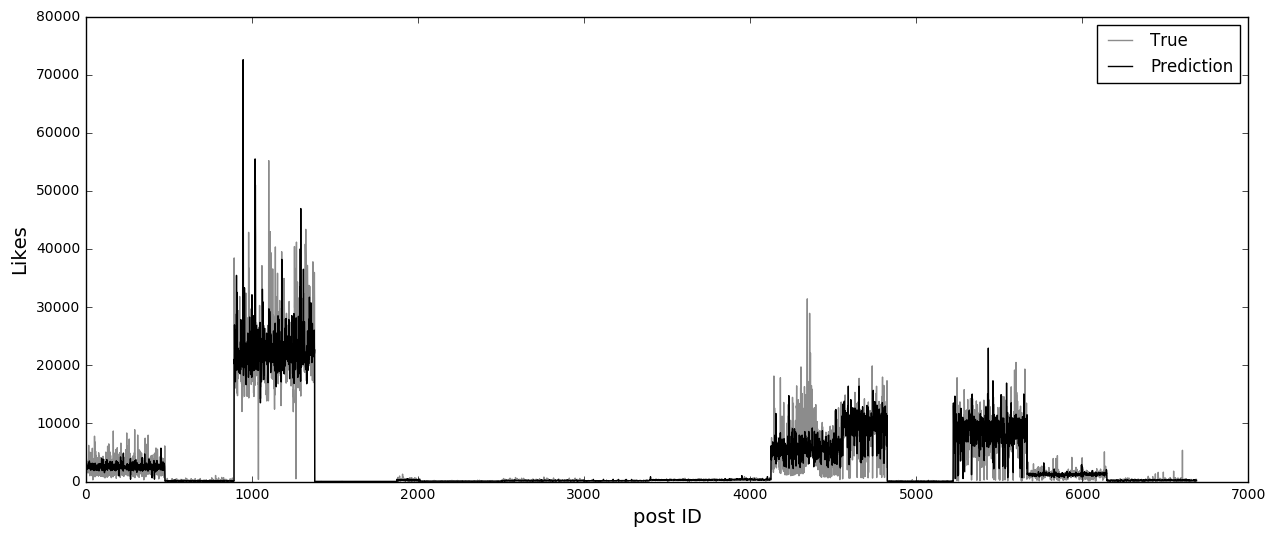

In [42]:
quality(true_likes, pred_raw*coef)
plot_error(true_likes, pred_raw*coef)

## KNN

In [23]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()

In [24]:
pred_raw_knn = cross_val_predict(knn, X_all_sparse, y, cv = kf, verbose = 10)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


MAE:
50.7790829276
MSE:
6424.91680183
RMSE:
80.1555787318


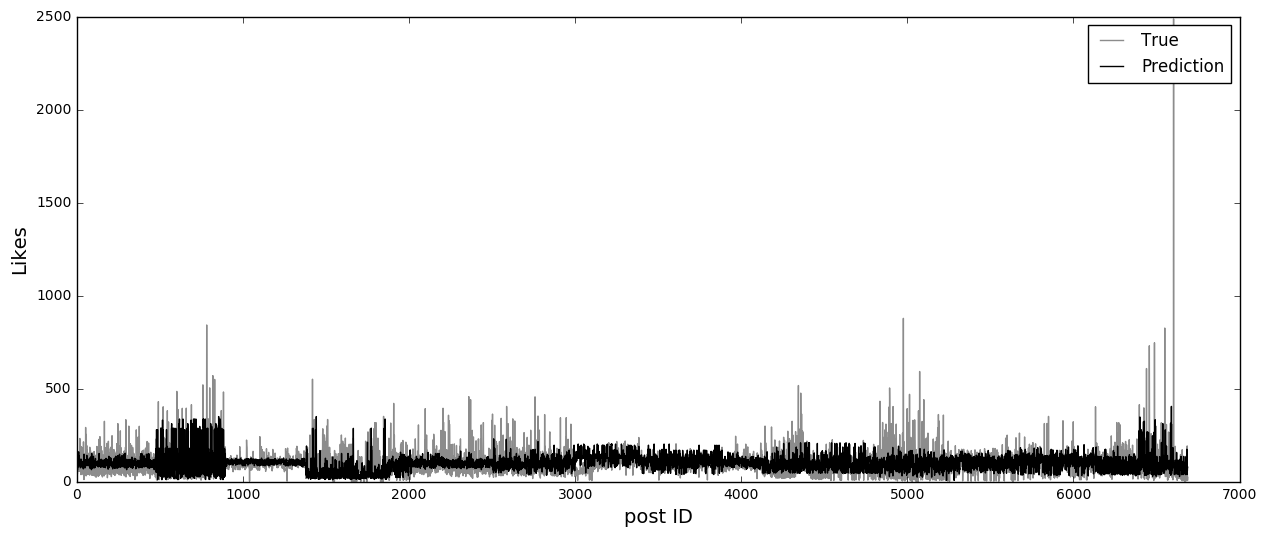

In [43]:
quality(y, pred_raw_knn)
plot_error(y, pred_raw_knn)

MAE:
1135.38393646
MSE:
7136549.59447
RMSE:
2671.43212425


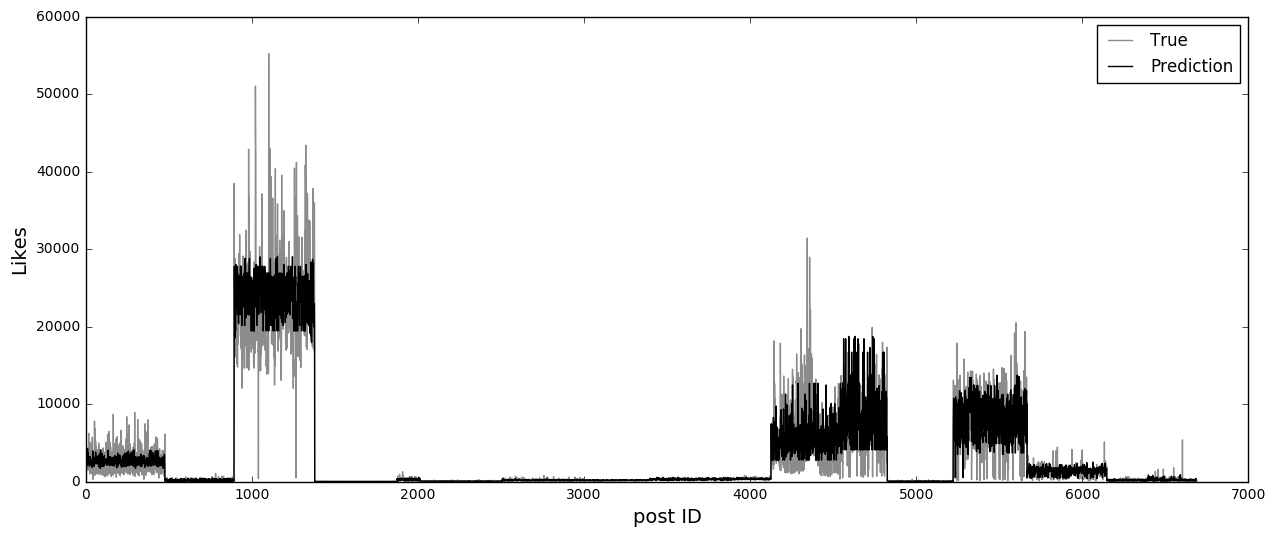

In [44]:
quality(true_likes, pred_raw_knn*coef)
plot_error(true_likes, pred_raw_knn*coef)

## Голосование

In [27]:
y_vote = pred_raw*0.7 + pred_raw_knn*0.3

MAE:
43.6708031037
MSE:
5129.01764307
RMSE:
71.6171602555


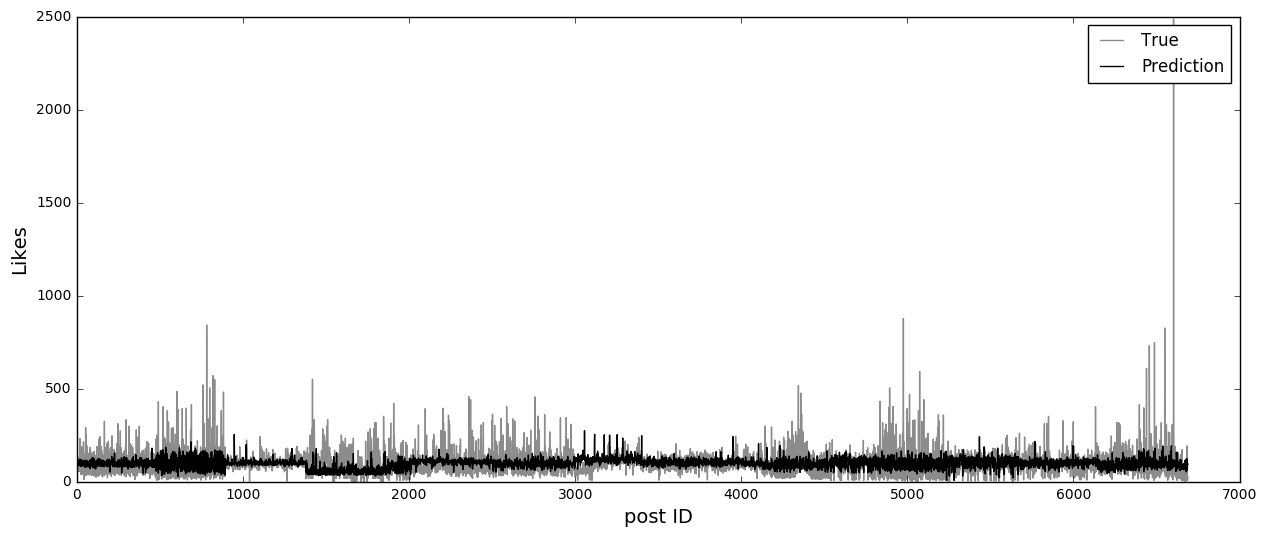

In [45]:
quality(y, y_vote)
plot_error(y, y_vote)

MAE:
987.419282495
MSE:
6075185.71655
RMSE:
2464.78918298


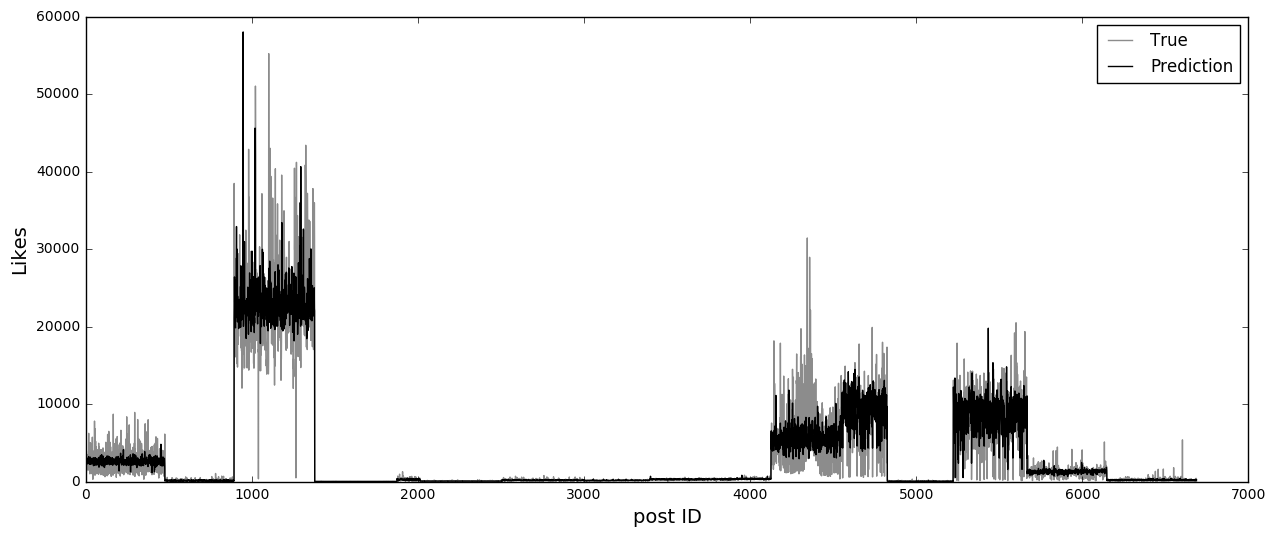

In [46]:
quality(true_likes, y_vote*coef)
plot_error(true_likes, y_vote*coef)

In [32]:
X.columns.shape

(12,)

In [38]:
columns = list(X.columns)

In [40]:
columns.append('Error')

In [55]:
differences = []
for i in range (len()):
    if y[i]/y_vote[i] > 1 and y_vote[i] != 0:
        differences.append(y[i]/y_vote[i])
    elif y[i] != 0:
        differences.append(y_vote[i]/y[i])
print(np.mean(differences))        

2.03184533876


In [50]:
## посты с наибольшей ошибкой предсказания
errors = np.abs(y_vote - y)
max_error_indices = np.argsort(errors)[-30:]
new_data = pd.DataFrame(columns = columns)
for i in max_error_indices:
    print(i)
    print(texts[i])
    print(X.iloc[i])
    print('Реальное значение больше на:')
    print(y[i] - y_vote[i])
    print(y[i]/y_vote[i])
    print('-----------------------------------------------------')
    
#     new_data.append(list(X.iloc[i]).extend(y_vote[i] - y[i]))


2370
Для всех, кто чувствует, что депрессия вот-вот затянет в свои темные сети, мы подготовили специальную подборку из 10 фильмов, которые помогут воспрянуть духом.
AttPhoto          0
AttLink           1
AttAudio          0
AttVideo          0
IsAdd             0
Len              23
Followers    612754
SentNeg           3
SentPos           2
ObsCount          0
copy              0
post              1
Name: 2370, dtype: int64
Реальное значение больше на:
329.142523205
3.98026176033
-----------------------------------------------------
5013
Хочу рассказать вам о невероятном художнике, обитающем здесь -  pixmilk Живой, смелый стиль, отличные сочные цвета, замечательное чувство композиции и анатомии. Казалось бы, круче уже некуда, но этим летом Константин удивил - нет, даже поразил! - аудиторию поистине космическими оттенками и ярким лайном.  У художника очень мягкая ненавязчивая монетизация в виде артбуков, что хорошо выделяется на фоне некоторых заносчивых крутанов с убеждением "деньги 

## Обучить и сохранить модели

In [256]:
frst.fit(X_all_sparse, y)
knn.fit(X_all_sparse, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [257]:
from sklearn.externals import joblib
knn_file = 'knn0.sav'
frst_file = 'frst0.sav'
joblib.dump(frst, frst_file)
joblib.dump(knn, knn_file)

['knn0.sav']